In [43]:
import dask as da
import dask.dataframe as daskdf
import dask.array as daa
import dask.distributed as dd
import dask.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import sklearn as sk
import numpy as np
import dask_ml.preprocessing as dm_pre
import dask_ml.cluster as dm_cluster
import dask_geopandas as dg
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from scipy.stats import pearsonr
import time

# Phase Four: Modeling. 
This phase involves selecting, applying, and tuning various statistical or machine learning models to your prepared data. Here's what typically happens in this phase:

In [44]:
# load preprocessed data
"""data head look like this: 
   mapped_veh_id       timestamps_UTC  RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  \
0          112.0  2023-08-01 11:42:55              309.15              313.15   
1          179.0  2023-08-24 17:48:07              314.15              303.15   
2          190.0  2023-08-01 12:27:13              307.15              313.15   
3          179.0  2023-08-24 18:18:05              311.15              304.15   
4          122.0  2023-08-01 12:53:12              303.15              304.15   

   RS_E_OilPress_PC1  RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  \
0              276.0              248.0         798.0         797.0   
1              220.0              227.0         796.0         798.0   
2              376.0              317.0        1236.0        1214.0   
3              220.0              220.0         802.0         799.0   
4              193.0              269.0         801.0         798.0   

   RS_E_WatTemp_PC1  RS_E_WatTemp_PC2  RS_T_OilTemp_PC1  RS_T_OilTemp_PC2  \
0            346.15            355.15            351.15            355.15   
1            355.15            356.15            352.15            355.15   
2            356.15            350.15            357.15            354.15   
3            355.15            355.15            353.15            355.15   
4            352.15            352.15            350.15            350.15   

   tempmax  tempmin  temp  
0     19.7     15.4  17.4  
...
2     19.7     15.1  17.2  
3     24.1     15.9  19.8  
4     19.7     15.4  17.4  
"""
# Load data
def load_data():
    print("Loading data...")
    start = time.time()
    df = daskdf.read_csv("preprocessed.csv")
    end = time.time()
    print("Data loaded in {} seconds".format(end-start))
    return df

In [45]:
ddf = load_data()
ddf = ddf.drop(columns=["Unnamed: 0"])
print(ddf.head())

Loading data...
Data loaded in 0.010226011276245117 seconds
   mapped_veh_id       timestamps_UTC  RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  \
0          112.0  2023-08-01 11:42:55              309.15              313.15   
1          179.0  2023-08-24 17:48:07              314.15              303.15   
2          190.0  2023-08-01 12:27:13              307.15              313.15   
3          179.0  2023-08-24 18:18:05              311.15              304.15   
4          122.0  2023-08-01 12:53:12              303.15              304.15   

   RS_E_OilPress_PC1  RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  \
0              276.0              248.0         798.0         797.0   
1              220.0              227.0         796.0         798.0   
2              376.0              317.0        1236.0        1214.0   
3              220.0              220.0         802.0         799.0   
4              193.0              269.0         801.0         798.0   

   RS_E_WatTemp_PC1  RS_E_

In [46]:
# Unsuppervised Modeling techniques selection
# 1. Isolation Forest: Effective for high-dimensional datasets. It isolates anomalies instead of modeling normal points, which is efficient when anomalies are rare.

# 2. Local Outlier Factor (LOF): It is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. can less effectively handle datasets with varying densities and lof is not well suited for high dimensional data. and it cannot handle the noise data. 

# 3. One-Class SVM: It is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set. It is based on the idea that a normal data point is surrounded by similar data points, while abnormal data points are far from their neighbors. It is effective in high dimensional spaces and it is memory efficient. It is not suited for large datasets and it does not perform well when the proportion of outliers is high.

# 4. DBSCAN: It is a density-based clustering algorithm that groups together points that are close to each other based on a distance measurement (usually Euclidean distance). It is effective for data which contains clusters of similar density. It is not suited for datasets with varying densities and it cannot handle noisy data.


In [47]:
# sample the data for testing 
#ddf = ddf.sample(frac=0.3, replace=False, random_state=1)


# 1. Isolation Forest


In [48]:
# Model implementation 

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# feature selection
# Since Isolation forest is a tree-based model, it can handle a high number of features. however, we will drop some features that are highly correlated with each other.
# We will use the Pearson correlation coefficient to identify highly correlated features and drop one of them.
# Pearson correlation coefficient is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

# Drop highly correlated features based on Pearso matrix previously calculated in data preprocessing
ddf = ddf.drop(columns=['RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2'])

# Drop non-feature columns
ddf = ddf.drop(columns=['tempmax', 'tempmin'])

ddf['timestamps_UTC'] = (ddf['timestamps_UTC'].astype('datetime64[ns]') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


# normaly we may not have again nan values, but just in case we will drop them
ddf = ddf.dropna()

# Normalize the feature columns
scaler = StandardScaler()
features_to_normalize = ddf.columns

# Convert Dask DataFrame to Pandas DataFrame for normalization if it fits in memory
df = ddf.compute()
# since it does not fit in memory, we use the following code to convert each partition to Pandas DataFrame, normalize, and convert back to Dask DataFrame
df = ddf.map_partitions(lambda df: df.apply(pd.to_numeric, errors='coerce')).compute()
df.dropna(inplace=True)
#df = ddf

# Normalize features
#df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.00001, random_state=42)  # 

# Fit the model (excluding non-feature columns)
#df = df.drop(columns=['mapped_veh_id', 'timestamps_UTC'])
#iso_forest.fit(model_features)
iso_forest.fit(df)

# Function to predict anomalies
def predict_anomalies(df):
    anomalies = iso_forest.predict(df)
    return pd.Series(anomalies, index=df.index, name='anomalies')

# Predict anomalies
df = df.assign(anomalies=df.map_partitions(predict_anomalies))

# Convert to 0 for normal, 1 for anomaly
df['anomalies'] = df['anomalies'].map({1: 0, -1: 1})
# Output the anomalies to a new CSV for further analysis
anomalies_df = df[df['anomalies'] == 1]
# save all part into single csv file
anomalies_df.to_csv('anomalies.csv')

C:\Users\nouss\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


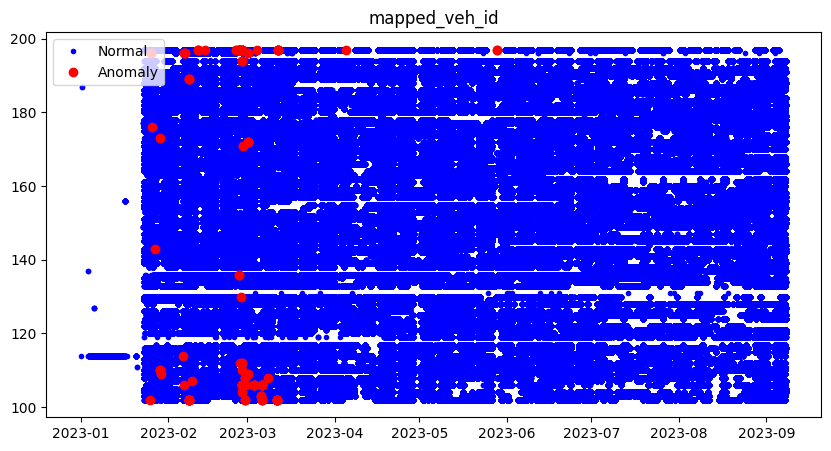

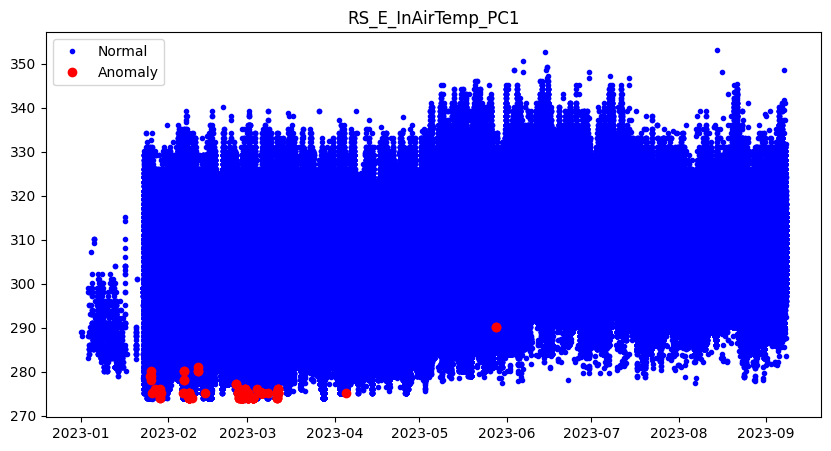

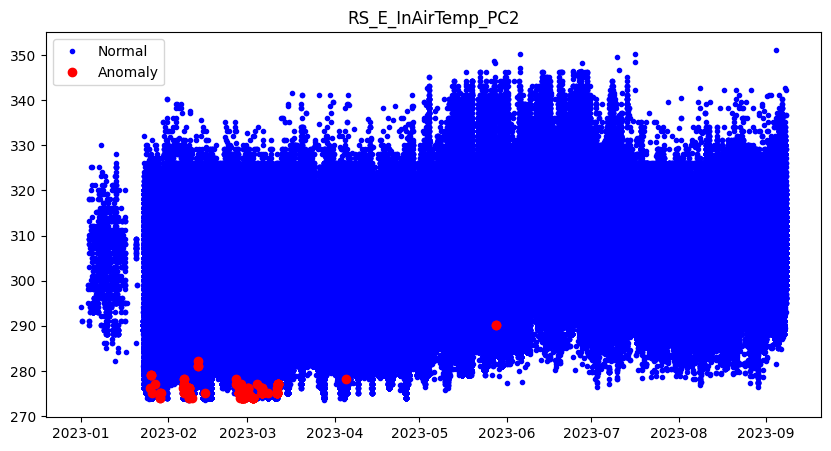

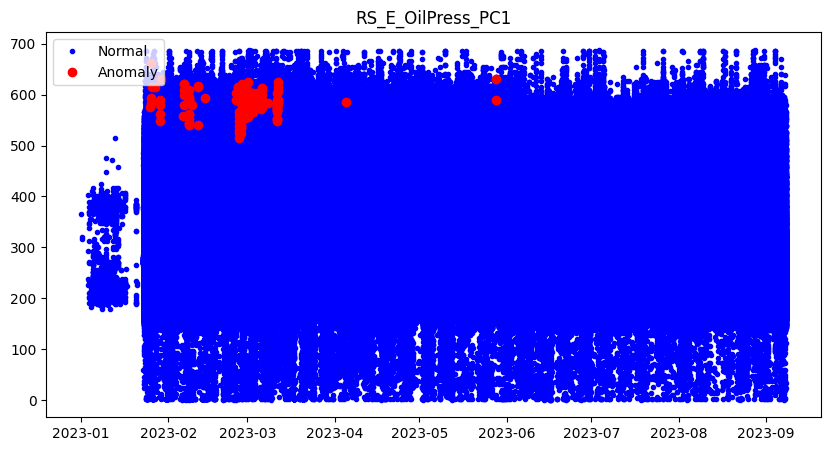

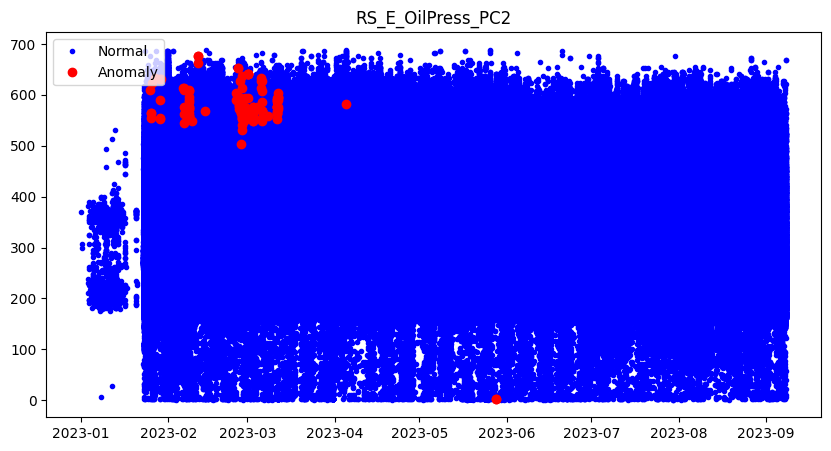

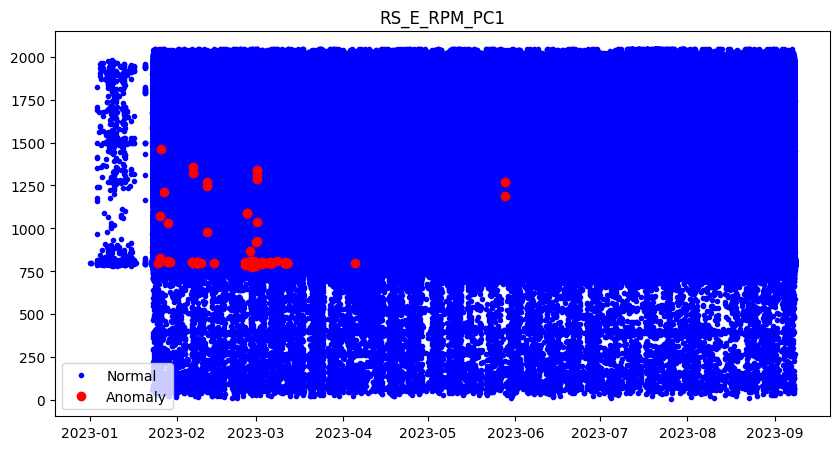

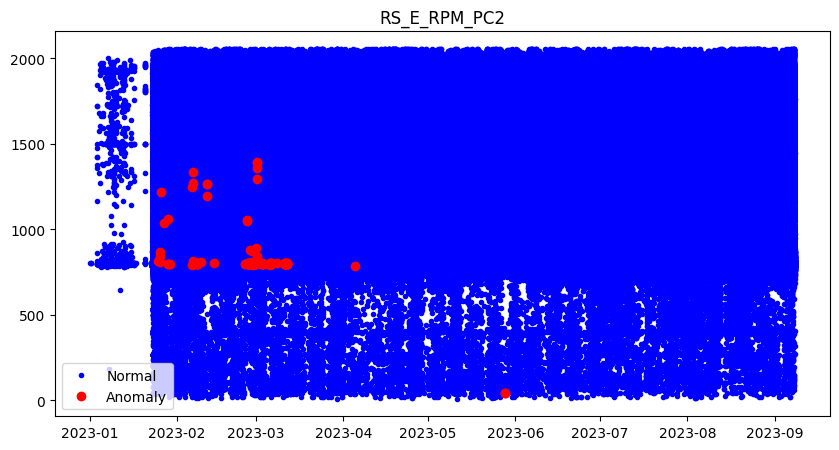

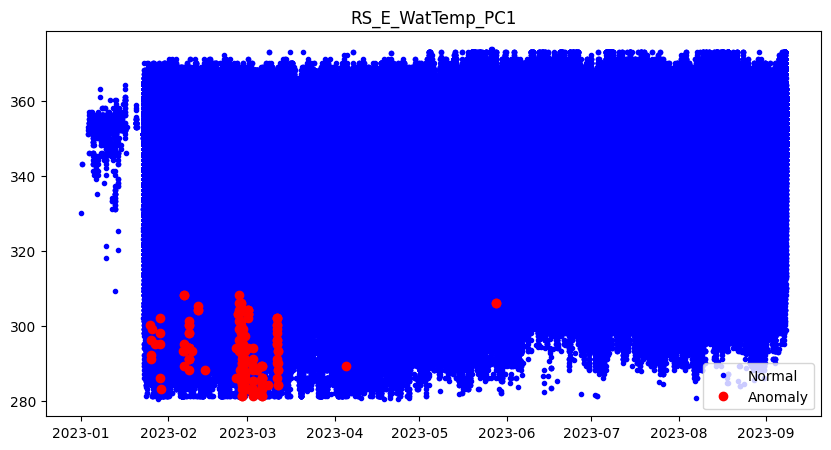

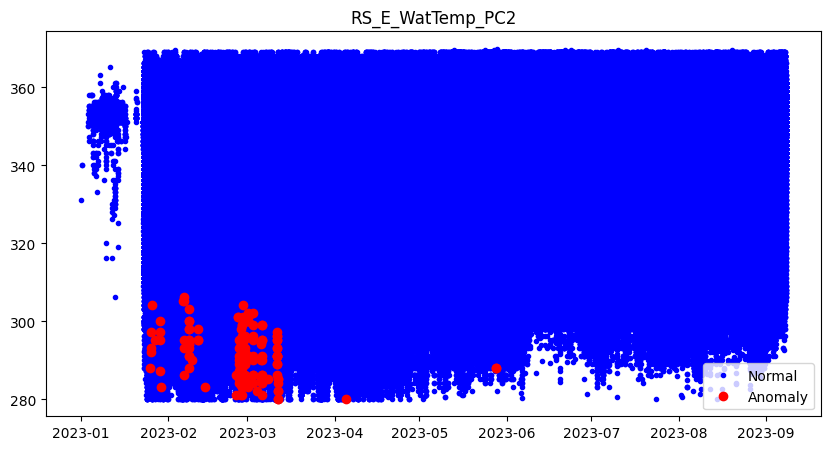

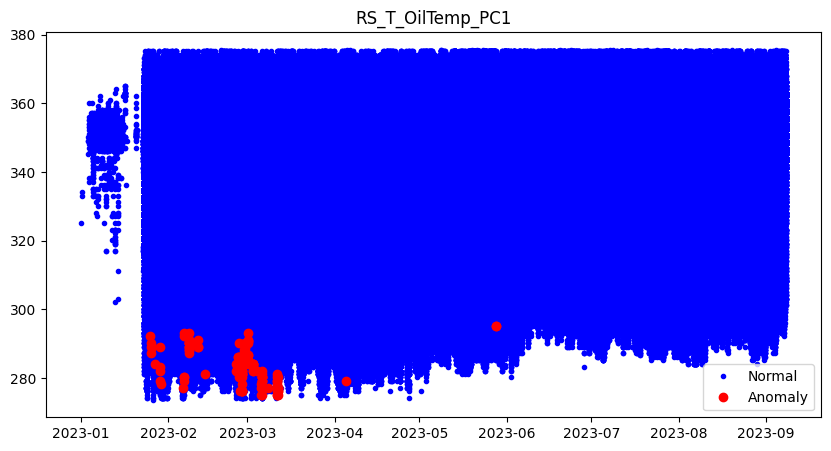

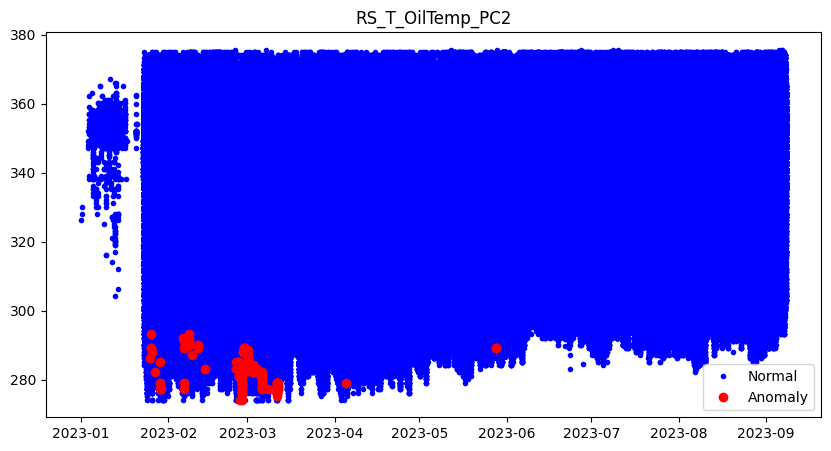

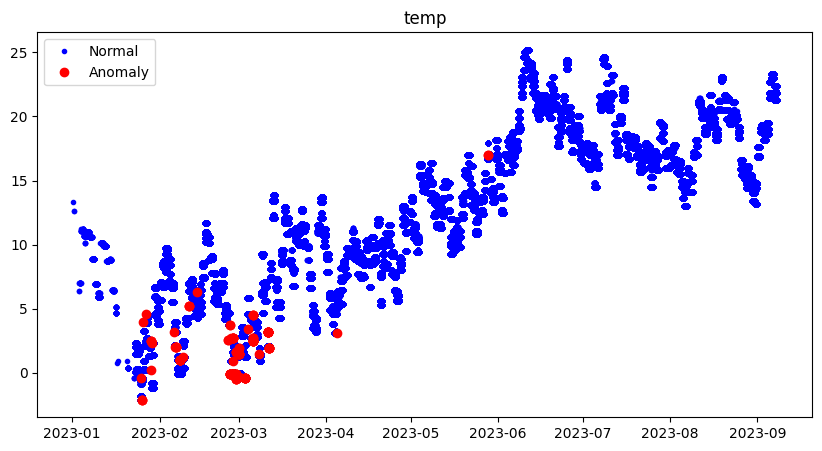

In [ ]:
import matplotlib.pyplot as plt

# Convert Dask DataFrame to Pandas DataFrame for plotting
df_pd = df.compute()
anomalies_df_pd = anomalies_df.compute()

# Set 'timestamps_UTC' as the index but convert it to datetime first
df_pd['timestamps_UTC'] = pd.to_datetime(df_pd['timestamps_UTC'], unit='s')
anomalies_df_pd['timestamps_UTC'] = pd.to_datetime(anomalies_df_pd['timestamps_UTC'], unit='s')

df_pd.set_index('timestamps_UTC', inplace=True)
anomalies_df_pd.set_index('timestamps_UTC', inplace=True)

# Plot the anomalies with legend of each feature
for feature in df_pd.drop(columns=['anomalies']).columns:
    plt.figure(figsize=(10, 5))
    plt.title(feature)
    plt.plot(df_pd[feature],'b.', label='Normal')
    plt.plot(anomalies_df_pd[feature], 'ro', label='Anomaly')
    plt.legend()
    plt.show()


In [ ]:
# model evaluation
# anomalies score 
anomalies_score = iso_forest.decision_function(df.drop(columns=['anomalies']))
# anomalies score distribution
sns.distplot(anomalies_score)
plt.title('Anomalies Score Distribution')
plt.xlabel('Anomalies Score')
plt.ylabel('Density')
plt.show()

# silhouette score
from sklearn.metrics import silhouette_score
silhouette_score(df, df['anomalies'])
print("silhouette score: ", silhouette_score(df, df['anomalies']))

# calinski harabasz score
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(df, df['anomalies'])
print("calinski harabasz score: ", calinski_harabasz_score(df, df['anomalies']))

# davies bouldin score
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(df, df['anomalies'])
print("davies bouldin score: ", davies_bouldin_score(df, df['anomalies']))


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk

# Assuming 'df' is your Pandas DataFrame converted from Dask DataFrame

# Sample the data
sample1 = df.sample(frac=0.0001, random_state=1)
sample2 = df.sample(frac=0.0001, random_state=2)

# Separate features and labels
sample1_features = sample1.drop(columns=['anomalies'])
sample1_labels = sample1['anomalies']
sample2_features = sample2.drop(columns=['anomalies'])
sample2_labels = sample2['anomalies']

# Evaluate the model on sample 1
sample1_predictions = iso_forest.predict(sample1_features)
sample1_predictions = pd.Series(sample1_predictions, index=sample1_features.index).map({1: 0, -1: 1})
sample1_metrics = {
    'Accuracy': sk.accuracy_score(sample1_labels, sample1_predictions),
    'Precision': sk.precision_score(sample1_labels, sample1_predictions),
    'Recall': sk.recall_score(sample1_labels, sample1_predictions),
    'F1 Score': sk.f1_score(sample1_labels, sample1_predictions),
    'Confusion Matrix': sk.confusion_matrix(sample1_labels, sample1_predictions)
}

# Evaluate the model on sample 2
sample2_predictions = iso_forest.predict(sample2_features)
sample2_predictions = pd.Series(sample2_predictions, index=sample2_features.index).map({1: 0, -1: 1})
sample2_metrics = {
    'Accuracy': sk.accuracy_score(sample2_labels, sample2_predictions),
    'Precision': sk.precision_score(sample2_labels, sample2_predictions),
    'Recall': sk.recall_score(sample2_labels, sample2_predictions),
    'F1 Score': sk.f1_score(sample2_labels, sample2_predictions),
    'Confusion Matrix': sk.confusion_matrix(sample2_labels, sample2_predictions)
}

# Print the results
print('Sample 1 Metrics:', sample1_metrics)
print('\nSample 2 Metrics:', sample2_metrics)

# Plotting
# Plot the confusion matrix for sample 1
plt.figure(figsize=(10, 5))
sns.heatmap(sample1_confusion_matrix, annot=True, fmt='d')
plt.title('Sample 1 Confusion Matrix')
plt.show()

# Plot the confusion matrix for sample 2
plt.figure(figsize=(10, 5))
sns.heatmap(sample2_confusion_matrix, annot=True, fmt='d')
plt.title('Sample 2 Confusion Matrix')
plt.show()

# Plot the anomalies with legend of each feature
for feature in sample1.columns:
    plt.figure(figsize=(10, 5))
    plt.title(feature)
    plt.plot(sample1[feature],'b.', label='Normal')
    plt.plot(sample1[sample1_predictions == 1][feature], 'ro', label='Anomaly')
    plt.legend()
    plt.show()

# Plot the anomalies with legend of each feature
for feature in sample2.columns:
    plt.figure(figsize=(10, 5))
    plt.title(feature)
    plt.plot(sample2[feature],'b.', label='Normal')
    plt.plot(sample2[sample2_predictions == 1][feature], 'ro', label='Anomaly')
    plt.legend()
    plt.show()


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


KeyboardInterrupt: 

# 2. Local Outlier Factor 

In [ ]:
#  LOF Model Implementation

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# feature selection
# Since LOF is a distance-based model, it is not suitable for high-dimensional datasets. So we will drop highly correlated features.
# Drop highly correlated features based on Pearso matrix previously calculated in data preprocessing
ddf = ddf.drop(columns=['RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2'])

# Drop non-feature columns
ddf = ddf.drop(columns=['tempmax', 'tempmin'])

ddf['timestamps_UTC'] = (ddf['timestamps_UTC'].astype('datetime64[ns]') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Normalize the feature columns
scaler = StandardScaler()
features_to_normalize = ddf.columns
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Initialize LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.00001)

# Fit the model (excluding non-feature columns)
df['lof_anomalies'] = lof.fit_predict(df[features_to_normalize])
df['lof_anomalies'] = df['lof_anomalies'].map({1: 0, -1: 1})  # Convert to 0 for normal, 1 for anomaly

# Review the detected anomalies
anomalies_lof = df[df['lof_anomalies'] == 1]
print(anomalies_lof)

# Output the anomalies to a new CSV for further analysis
anomalies_lof.to_csv('anomalies_lof.csv')




ValueError: Metadata inference failed in `drop_by_shallow_copy`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError("['tempmax', 'tempmin'] not found in axis")

Traceback:
---------
  File "c:\Python311\Lib\site-packages\dask\dataframe\utils.py", line 194, in raise_on_meta_error
    yield
  File "c:\Python311\Lib\site-packages\dask\dataframe\core.py", line 7055, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\dask\dataframe\utils.py", line 773, in drop_by_shallow_copy
    df2.drop(columns=columns, inplace=True, errors=errors)
  File "c:\Python311\Lib\site-packages\pandas\core\frame.py", line 5344, in drop
    return super().drop(
           ^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\pandas\core\generic.py", line 4711, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\pandas\core\generic.py", line 4753, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 6992, in drop
    raise KeyError(f"{labels[mask].tolist()} not found in axis")


In [ ]:
# Plot the anomalies with legend of each feature
for feature in df.drop(columns=['lof_anomalies']).columns:
    plt.figure(figsize=(10, 5))
    plt.title(feature)
    plt.plot(df[feature],'b.', label='Normal')
    plt.plot(anomalies_lof[feature], 'ro', label='Anomaly')
    plt.legend()
    plt.show()


    

In [ ]:
# Evaluate the model on sample 1
sample1_predictions = lof.fit_predict(sample1_features)
sample1_predictions = pd.Series(sample1_predictions, index=sample1_features.index).map({1: 0, -1: 1})
sample1_metrics = {
    'Accuracy': sk.accuracy_score(sample1_labels, sample1_predictions),
    'Precision': sk.precision_score(sample1_labels, sample1_predictions),
    'Recall': sk.recall_score(sample1_labels, sample1_predictions),
    'F1 Score': sk.f1_score(sample1_labels, sample1_predictions),
    'Confusion Matrix': sk.confusion_matrix(sample1_labels, sample1_predictions)
}

# Evaluate the model on sample 2
sample2_predictions = lof.fit_predict(sample2_features)
sample2_predictions = pd.Series(sample2_predictions, index=sample2_features.index).map({1: 0, -1: 1})
sample2_metrics = {
    'Accuracy': sk.accuracy_score(sample2_labels, sample2_predictions),
    'Precision': sk.precision_score(sample2_labels, sample2_predictions),
    'Recall': sk.recall_score(sample2_labels, sample2_predictions),
    'F1 Score': sk.f1_score(sample2_labels, sample2_predictions),
    'Confusion Matrix': sk.confusion_matrix(sample2_labels, sample2_predictions)
}

# Print the results
print('Sample 1 Metrics:', sample1_metrics)
print('\nSample 2 Metrics:', sample2_metrics)
